<a href="https://colab.research.google.com/github/Mulingedzi/OBD-II-DATASET-TRAINING/blob/main/Training_OBDII.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving live1.csv to live1.csv
Class distribution:
 FAULT_LABEL
1    2252
0    1601
Name: count, dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count



Random Forest Metrics:
Accuracy=0.8495, Precision=0.8984, Recall=0.8054, F1=0.8494, ROC-AUC=0.9130, PR-AUC=0.9383
Inference latency: 0.5700 seconds


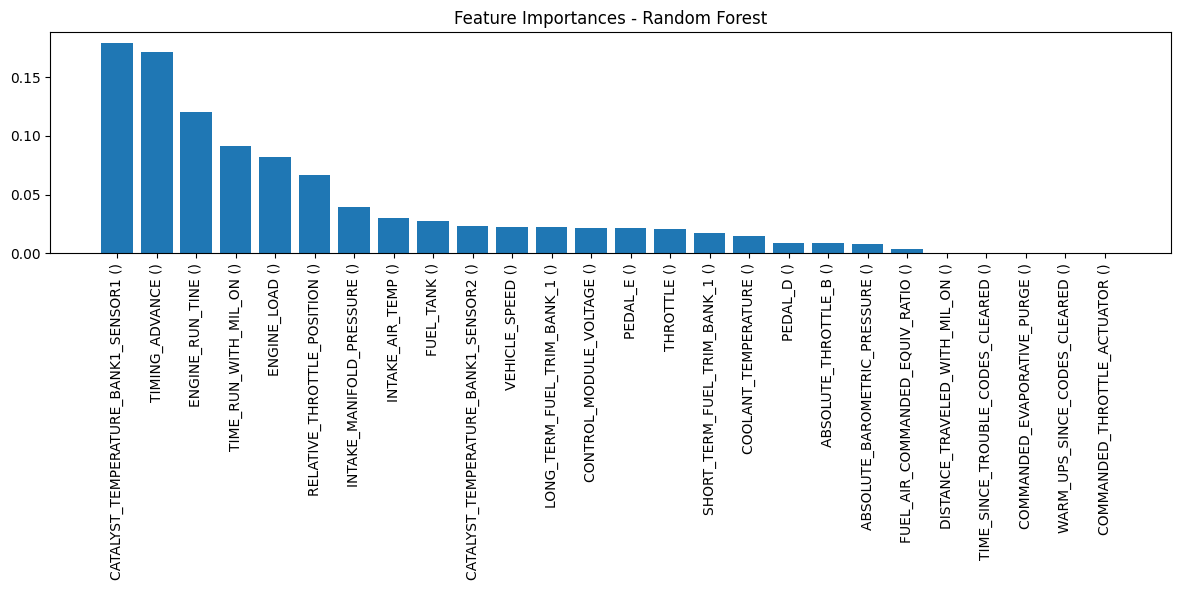

In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import matplotlib.pyplot as plt
import io
from google.colab import files
import time

# Step 2: Upload CSV
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[file_name]))

# Step 3: Handle missing values (fill NaN with mean)
df_filled = df.fillna(df.mean())

# Step 4: Select numeric columns
numeric_cols = df_filled.select_dtypes(include=np.number).columns.tolist()
df_numeric = df_filled[numeric_cols]

# Step 5: Scale features
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_numeric), columns=numeric_cols)

# Step 6: Define features and target
target = 'ENGINE_RPM ()'
features = df_scaled.columns.tolist()
features.remove(target)

# Step 7: Convert target into binary fault label using ±1 std deviation
threshold_upper = df_scaled[target].mean() + df_scaled[target].std()
threshold_lower = df_scaled[target].mean() - df_scaled[target].std()

df_scaled['FAULT_LABEL'] = ((df_scaled[target] > threshold_upper) | (df_scaled[target] < threshold_lower)).astype(int)
print("Class distribution:\n", df_scaled['FAULT_LABEL'].value_counts())

# Step 8: Time-aware train-test split
train_size = 0.8
train_len = int(len(df_scaled) * train_size)

X_train = df_scaled.iloc[:train_len][features]
y_train = df_scaled.iloc[:train_len]['FAULT_LABEL']

X_test = df_scaled.iloc[train_len:][features]
y_test = df_scaled.iloc[train_len:]['FAULT_LABEL']

# Step 9: Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

start_time = time.time()
rf_model.fit(X_train, y_train)
latency = time.time() - start_time

# Step 10: Make predictions
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:,1]  # probability for ROC-AUC/PR-AUC

# Step 11: Evaluate model
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("\nRandom Forest Metrics:")
print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}")
print(f"Inference latency: {latency:.4f} seconds")

# Step 12: Feature importance visualization
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Feature Importances - Random Forest")
plt.bar(range(len(features)), importances[indices], align='center')
plt.xticks(range(len(features)), [features[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()


In [2]:
# Ensure no NaNs in training and testing data
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

# Clean column names for consistency
X_train.columns = X_train.columns.str.replace(" ", "_").str.replace("()", "")
X_test.columns = X_test.columns.str.replace(" ", "_").str.replace("()", "")



Number of anomalies detected (top 5% threshold): 39
Confusion Matrix for Isolation Forest:
[[326  39]
 [406   0]]


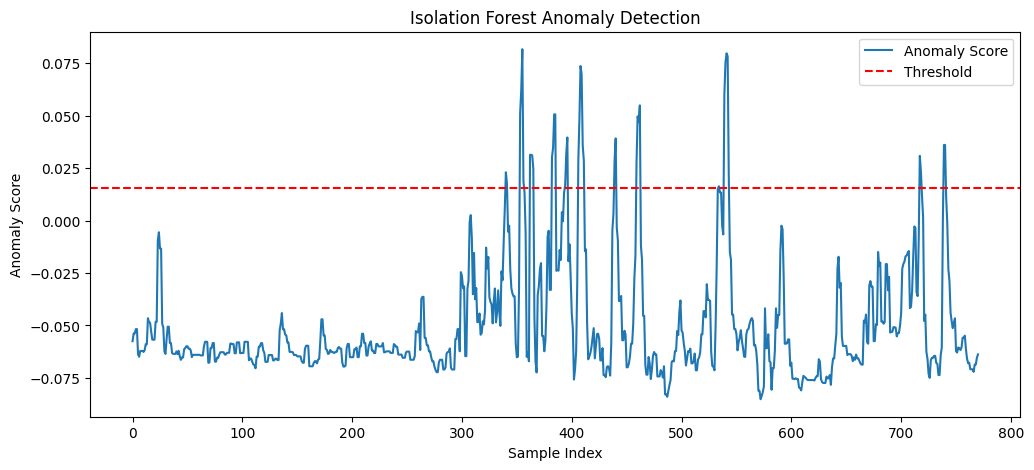

In [3]:
from sklearn.ensemble import IsolationForest

# Train Isolation Forest on training features
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on test set
anomaly_labels = iso_forest.predict(X_test)  # -1 for anomaly, 1 for normal
anomaly_score = -iso_forest.decision_function(X_test)  # higher score = more anomalous

# Apply contamination-adjusted threshold
threshold = np.percentile(anomaly_score, 95)  # top 5% as anomalies
predicted_anomalies = (anomaly_score > threshold).astype(int)

# Count anomalies
print(f"Number of anomalies detected (top 5% threshold): {predicted_anomalies.sum()}")

# Optional: Compute simple metrics if labels exist
if 'FAULT_LABEL' in df_scaled.columns:
    from sklearn.metrics import confusion_matrix
    # Map original test labels to 0/1
    y_test_binary = y_test.values
    cm = confusion_matrix(y_test_binary, predicted_anomalies)
    print("Confusion Matrix for Isolation Forest:")
    print(cm)

# Visualize anomaly scores
plt.figure(figsize=(12,5))
plt.plot(anomaly_score, label='Anomaly Score')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Sample Index')
plt.ylabel('Anomaly Score')
plt.legend()
plt.show()




In [4]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score
import time

# Train LGBM Classifier
lgb_model = lgb.LGBMClassifier(n_estimators=100, random_state=42, class_weight='balanced')

start_time = time.time()
lgb_model.fit(X_train, y_train)
lgb_latency = time.time() - start_time

# Predictions
y_pred_lgb = lgb_model.predict(X_test)
y_prob_lgb = lgb_model.predict_proba(X_test)[:,1]

# Metrics
acc_lgb = accuracy_score(y_test, y_pred_lgb)
prec_lgb = precision_score(y_test, y_pred_lgb, zero_division=0)
rec_lgb = recall_score(y_test, y_pred_lgb, zero_division=0)
f1_lgb = f1_score(y_test, y_pred_lgb, zero_division=0)
roc_auc_lgb = roc_auc_score(y_test, y_prob_lgb)
pr_auc_lgb = average_precision_score(y_test, y_prob_lgb)

print("\nLightGBM Metrics:")
print(f"Accuracy={acc_lgb:.4f}, Precision={prec_lgb:.4f}, Recall={rec_lgb:.4f}, F1={f1_lgb:.4f}, ROC-AUC={roc_auc_lgb:.4f}, PR-AUC={pr_auc_lgb:.4f}")
print(f"Inference latency: {lgb_latency:.4f} seconds")


[LightGBM] [Info] Number of positive: 1846, number of negative: 1236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1758
[LightGBM] [Info] Number of data points in the train set: 3082, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

LightGBM Metrics:
Accuracy=0.8508, Precision=0.9619, Recall=0.7463, F1=0.8405, ROC-AUC=0.9547, PR-AUC=0.9647
Inference latency: 0.2482 seconds


<Figure size 640x480 with 0 Axes>

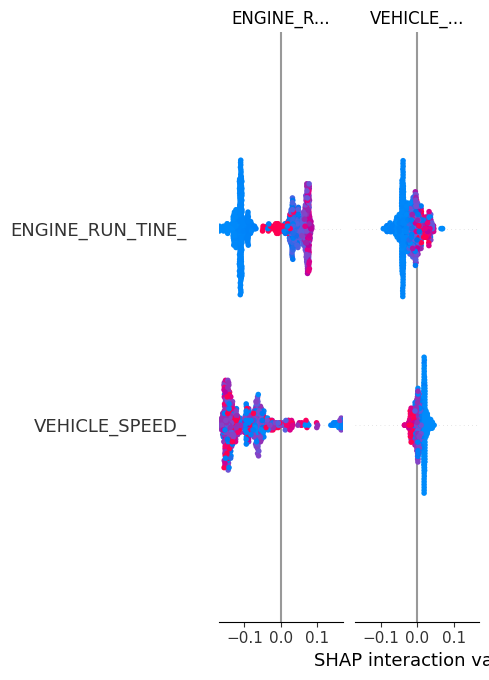

In [5]:
import shap

# Create SHAP explainer for Random Forest
explainer_rf = shap.TreeExplainer(rf_model)
shap_values_rf = explainer_rf.shap_values(X_test)

# --- FIX SHAP INDEXING BASED ON OUTPUT TYPE ---
# Case 1: shap_values is a list (multi-output or class-specific)
if isinstance(shap_values_rf, list):
    # Use class 1 SHAP values if available, otherwise the first element
    shap_vals_to_plot = shap_values_rf[1] if len(shap_values_rf) > 1 else shap_values_rf[0]

# Case 2: shap_values is a single numpy array (binary classification)
else:
    shap_vals_to_plot = shap_values_rf

# Plot SHAP summary
plt.figure()
shap.summary_plot(shap_vals_to_plot, X_test, plot_type="bar", show=True)



Detected LightGBM model: lgb_model
Detected LightGBM model: lgbm_model


/usr/local/lib/python3.12/dist-packages/shap/explainers/_tree.py:587: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


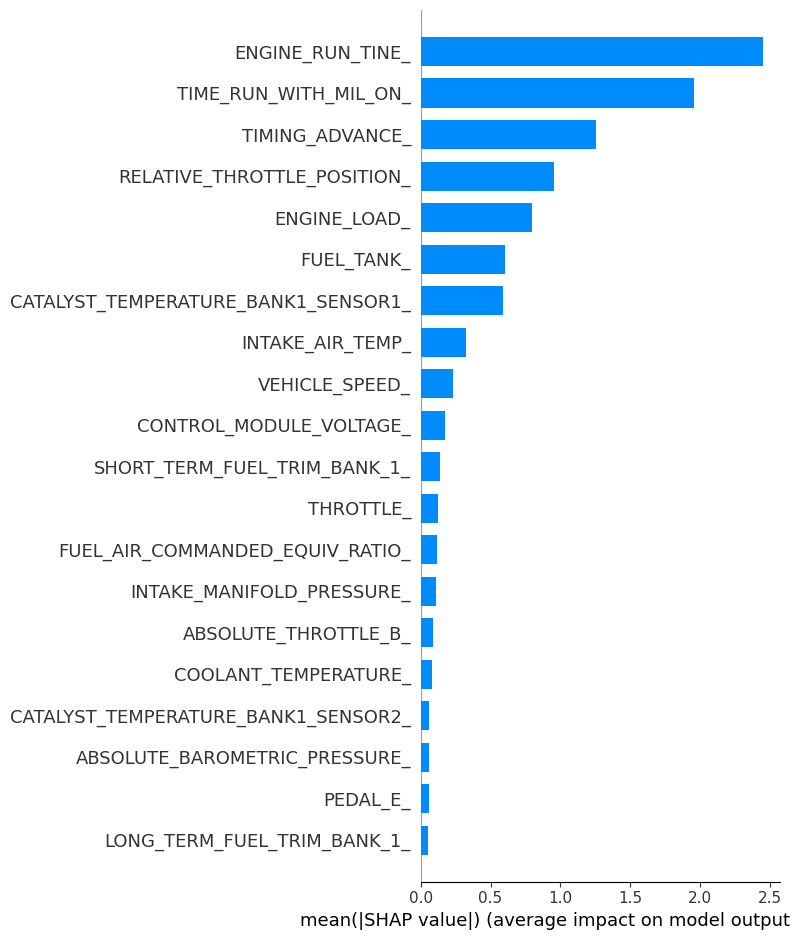

In [6]:
import shap

# --- Identify the LightGBM model automatically ---
# Look for any variable in the notebook that is a LightGBM model
lgbm_model = None
for var_name in dir():
    var_value = globals()[var_name]
    if str(type(var_value)).startswith("<class 'lightgbm.sklearn.LGBM"):
        lgbm_model = var_value
        print(f"Detected LightGBM model: {var_name}")

if lgbm_model is None:
    raise NameError("No LightGBM model found. Please check your model variable name.")

# --- SHAP analysis ---
explainer_lgbm = shap.TreeExplainer(lgbm_model)
shap_values_lgbm = explainer_lgbm.shap_values(X_test)

# Handle different SHAP output shapes
if isinstance(shap_values_lgbm, list):
    shap_vals_to_plot_lgbm = shap_values_lgbm[1] if len(shap_values_lgbm) > 1 else shap_values_lgbm[0]
else:
    shap_vals_to_plot_lgbm = shap_values_lgbm

plt.figure()
shap.summary_plot(shap_vals_to_plot_lgbm, X_test, plot_type="bar", show=True)


In [7]:
print("=== Model Comparison ===")
print("Random Forest:")
print(f"Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}, ROC-AUC={roc_auc:.4f}, PR-AUC={pr_auc:.4f}, Latency={latency:.4f}s\n")

print("LightGBM:")
print(f"Accuracy={acc_lgb:.4f}, Precision={prec_lgb:.4f}, Recall={rec_lgb:.4f}, F1={f1_lgb:.4f}, ROC-AUC={roc_auc_lgb:.4f}, PR-AUC={pr_auc_lgb:.4f}, Latency={lgb_latency:.4f}s\n")

print("Isolation Forest:")
print(f"Anomalies detected: {predicted_anomalies.sum()}, Threshold: {threshold:.4f}")


=== Model Comparison ===
Random Forest:
Accuracy=0.8495, Precision=0.8984, Recall=0.8054, F1=0.8494, ROC-AUC=0.9130, PR-AUC=0.9383, Latency=0.5700s

LightGBM:
Accuracy=0.8508, Precision=0.9619, Recall=0.7463, F1=0.8405, ROC-AUC=0.9547, PR-AUC=0.9647, Latency=0.2482s

Isolation Forest:
Anomalies detected: 39, Threshold: 0.0157


In [8]:
df.head(5)

,ENGINE_RUN_TINE (),ENGINE_RPM (),VEHICLE_SPEED (),THROTTLE (),ENGINE_LOAD (),COOLANT_TEMPERATURE (),LONG_TERM_FUEL_TRIM_BANK_1 (),SHORT_TERM_FUEL_TRIM_BANK_1 (),INTAKE_MANIFOLD_PRESSURE (),FUEL_TANK (),...,INTAKE_AIR_TEMP (),TIMING_ADVANCE (),CATALYST_TEMPERATURE_BANK1_SENSOR1 (),CATALYST_TEMPERATURE_BANK1_SENSOR2 (),CONTROL_MODULE_VOLTAGE (),COMMANDED_EVAPORATIVE_PURGE (),TIME_RUN_WITH_MIL_ON (),TIME_SINCE_TROUBLE_CODES_CLEARED (),DISTANCE_TRAVELED_WITH_MIL_ON (),WARM_UPS_SINCE_CODES_CLEARED ()
0.0,0.0,0.0,17.647058,0.0,25.0,-2.34375,0.0,101.0,36.07843,49.803921,...,5.0,434.700012,295.100006,12.324,0.0,0.0,7835.0,0.0,255.0,NaN
0.0,0.0,0.0,17.647058,0.0,25.0,-2.34375,0.0,101.0,36.07843,49.803921,...,5.0,434.700012,295.100006,12.343,0.0,0.0,7835.0,0.0,255.0,NaN
0.0,0.0,0.0,17.647058,0.0,25.0,-2.34375,0.0,101.0,36.07843,49.803921,...,5.0,434.700012,295.100006,12.343,0.0,0.0,7835.0,0.0,255.0,NaN
0.0,0.0,0.0,18.039215,0.0,25.0,-2.34375,0.0,101.0,36.07843,49.803921,...,5.0,434.700012,295.100006,12.343,0.0,0.0,7835.0,0.0,255.0,NaN
0.0,0.0,0.0,18.039215,0.0,25.0,-2.34375,0.0,101.0,36.07843,49.803921,...,5.0,434.700012,295.100006,12.343,0.0,0.0,7835.0,0.0,255.0,NaN
